In [1]:
import pymongo
import IPython.display as ipd
import pydub
import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_client.list_database_names()

['admin', 'config', 'ece590', 'local']

In [3]:
mongo_db = mongo_client['ece590']
mongo_db.list_collection_names()

['filtered_cache']

In [4]:
mongo_collection = mongo_db['filtered_cache']

In [17]:
file_name = '/gmu_ece590/project/XC318733-SouthGeorgia Pipit_Salisbury_24dec2015_Fschmitt_8.mp3'

with open( file_name, 'rb' ) as file:
    file_content = file.read()
    
new_entry = {
    'file_name': file_name,
    'filter_edges': [0.0, 0.1, 0.2, 0.5],
    'filter_amplitude': [1., 0.0],
    'file_content': file_content
}
mongo_collection.insert_one( new_entry )

/gmu_ece590/project/XC318733-SouthGeorgia Pipit_Salisbury_24dec2015_Fschmitt_8.mp3
/gmu_ece590/project/XC318733-SouthGeorgia Pipit_Salisbury_24dec2015_Fschmitt_8.mp3
/gmu_ece590/project/XC318733-SouthGeorgia Pipit_Salisbury_24dec2015_Fschmitt_8.mp3
/gmu_ece590/project/XC318733-SouthGeorgia Pipit_Salisbury_24dec2015_Fschmitt_8.mp3


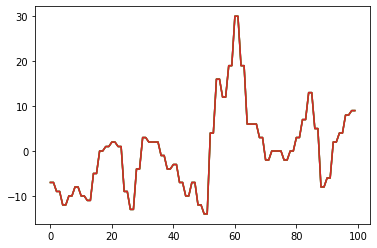

In [5]:
results = mongo_collection.find( { 'filter_amplitude': [1.0, 0.0] } )
for result in results:
    print( result['file_name'] )
    file_content = result.get( 'file_content' )
    if( file_content is not None ):
        sound = pydub.AudioSegment.from_mp3( io.BytesIO( file_content ) )
        samples = sound.get_array_of_samples()
        plt.plot(samples[1000:1100])
        
plt.show()

In [6]:
ipd.Audio(file_content)



In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("ECE590") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ece590.filtered_cache") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/ece590.filtered_cache") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.1') \
    .getOrCreate()

In [8]:
df = spark.read \
    .format("com.mongodb.spark.sql.DefaultSource") \
    .option("database","ece590") \
    .option("collection", "filtered_cache") \
    .load()

In [9]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- file_content: binary (nullable = true)
 |-- file_name: string (nullable = true)
 |-- filter_amplitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- filter_edges: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [10]:
df.drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5eaf69572ff03a1e...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
|[5eb1eef78c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.3, 0.4, 0.5]|
|[5eb1ef138c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
|[5eb1efd28c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|                null|
+--------------------+--------------------+----------------+--------------------+



In [12]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import BooleanType

def list_compare( mongo_list, desired_list ):
    if None is mongo_list:
        return False
    
    if len( mongo_list ) != len( desired_list ):
        return False
    
    for li, le in enumerate( desired_list ):
        if mongo_list[li] != le:
            return False
        
    return True

def udf_list_compare( desired_list ):
    return udf( lambda mongo_list: list_compare( mongo_list, desired_list ), BooleanType() )

df.filter( udf_list_compare( [1.0, 0.0] )( col('filter_amplitude') ) ).drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5eaf69572ff03a1e...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
|[5eb1eef78c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.3, 0.4, 0.5]|
|[5eb1ef138c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
|[5eb1efd28c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|                null|
+--------------------+--------------------+----------------+--------------------+



In [13]:
df.filter( udf_list_compare( [0.0, 0.1, 0.2, 0.5] )( col('filter_edges') ) ).drop('file_content').show()

+--------------------+--------------------+----------------+--------------------+
|                 _id|           file_name|filter_amplitude|        filter_edges|
+--------------------+--------------------+----------------+--------------------+
|[5eaf69572ff03a1e...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
|[5eb1ef138c9e5a3a...|/gmu_ece590/proje...|      [1.0, 0.0]|[0.0, 0.1, 0.2, 0.5]|
+--------------------+--------------------+----------------+--------------------+

